In [1]:
import argparse
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import requests
from pydantic import BaseModel
from transformer_lens import HookedTransformer
from tqdm import tqdm

/mnt/vast/home/lawrence/steer-llama/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class SteeringResult:
    layer: int
    alpha: float
    prompt: str
    response: str
    coherence_score: int
    trait_score: float
    

class CoherenceJudgment(BaseModel):
    justification: str
    answer: int  # 0 or 1

In [3]:
def load_steering_vectors(vectors_path: str) -> Dict[str, torch.Tensor]:
    """Load steering vectors from file."""
    return torch.load(vectors_path, map_location='cpu')


def create_steering_hook(steering_vector: torch.Tensor, alpha: float):
    """Create a hook function that adds steering vector to residual stream."""
    def steering_hook(activations, hook):
        # activations shape: (batch_size, seq_len, hidden_dim)
        # Ensure steering vector matches activation device and dtype; operate out-of-place
        vector = steering_vector.to(device=activations.device, dtype=activations.dtype)
        return activations + alpha * vector
    return steering_hook

In [4]:
def hooked_generate(hooked_model: HookedTransformer, input_tokens, max_tokens, layer_name, hook_fn, temperature=0.7, do_sample=True, top_p=0.9, **kwargs):
    """Custom generation loop using hooked forward passes."""
    
    # Start with the initial input tokens
    generated_ids = input_tokens.clone()
    
    for _ in tqdm(range(max_tokens)):
        # Run forward pass with hooks
        logits = hooked_model.run_with_hooks(
            generated_ids, 
            return_type="logits",
            fwd_hooks=[(layer_name, hook_fn)]
        )
        
        # Apply temperature scaling
        if do_sample and temperature != 1.0:
            logits = logits / temperature
        
        # Get next token
        if do_sample:
            # Apply top-p (nucleus) sampling if specified
            if top_p < 1.0:
                # Sort logits and get cumulative probabilities
                sorted_logits, sorted_indices = torch.sort(logits[0, -1], descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Keep at least one token
                sorted_indices_to_remove[0] = False
                
                # Set logits of removed tokens to -inf
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[0, -1, indices_to_remove] = float('-inf')
            
            # Sample from the distribution
            probs = torch.softmax(logits[0, -1], dim=-1)
            next_token = torch.multinomial(probs, 1)
        else:
            # Greedy sampling
            next_token = logits[0, -1].argmax().unsqueeze(0)
        
        # Reshape to match expected dimensions
        next_token = next_token.unsqueeze(0)

        # Append the new token
        # move everything to cuda:0
        generated_ids = generated_ids.to("cuda:0")
        next_token = next_token.to("cuda:0")
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # Check for EOS token (optional - depends on your tokenizer)
        if hasattr(hooked_model.tokenizer, 'eos_token_id') and next_token.item() == hooked_model.tokenizer.eos_token_id:
            break
    
    return generated_ids

In [88]:
def generate_steered_response(
    model: HookedTransformer,
    tokenizer,
    prompt: str,
    layer_name: str,
    steering_vector: torch.Tensor,
    alpha: float,
    max_tokens: int = 256,
    temperature: float = 0.7,
    do_sample: bool = True,
    top_p: float = 0.9
) -> str:
    """Generate response with steering applied at specified layer."""
    
    # Prepare input
    # try:
    #     # Try to use chat template if available
    #     messages = [
    #         {"role": "user", "content": prompt}
    #     ]
    #     input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # except (ValueError, AttributeError):
    #     # Fallback to raw prompt if no chat template
    #     print("Warning: No chat template available, using raw prompt")
    #     input_text = prompt
    
    # Tokenize
    input_tokens = model.to_tokens(prompt)
    
    # Add steering hook
    hook_fn = create_steering_hook(steering_vector, alpha)
    
    # Generate with steering using custom loop
    with torch.no_grad():
        generated_ids = hooked_generate(
            model, 
            input_tokens, 
            max_tokens, 
            layer_name, 
            hook_fn,
            temperature=temperature,
            do_sample=do_sample,
            top_p=top_p
        )
    
    # Decode response (skip original input)
    response = tokenizer.decode(generated_ids[0][input_tokens.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [6]:
def evaluate_coherence(response: str, prompt: str) -> int:
    """Evaluate response coherence using Qwen3 API."""
    
    coherence_prompt = f"""You are evaluating whether a response is coherent and makes sense.

Prompt: {prompt}
Response: {response}

A coherent response should:
1. Be grammatically correct and well-structured
2. Make logical sense and stay on topic
3. Be appropriate for the given prompt
4. Not contain contradictions or nonsensical statements

Respond with a JSON object containing:
- justification: Brief explanation of your assessment
- answer: 0 if incoherent, 1 if coherent"""

    try:
        response_obj = requests.post(
            "http://172.28.127.109:8010/v1/chat/completions",
            json={
                "model": "qwen3-235b-reasoning",
                "messages": [{"role": "user", "content": coherence_prompt}],
                "temperature": 0.0,
                "max_tokens": 200
            },
            timeout=30
        )
        
        if response_obj.status_code == 200:
            result = response_obj.json()
            content = result['choices'][0]['message']['content']
            
            # Parse JSON response
            judgment = CoherenceJudgment.model_validate_json(content)
            return judgment.answer
        else:
            print(f"Coherence API error: {response_obj.status_code}")
            return 1  # Default to coherent if API fails
            
    except Exception as e:
        print(f"Coherence evaluation error: {e}")
        return 1  # Default to coherent if evaluation fails

In [7]:
def evaluate_trait_expression(response: str, prompt: str, eval_prompt_template: str) -> float:
    """Evaluate emoji trait expression using the existing eval prompt."""
    
    eval_prompt = eval_prompt_template.format(question=prompt, answer=response)
    
    try:
        response_obj = requests.post(
            "http://172.28.127.109:8010/v1/chat/completions",
            json={
                "model": "qwen3-235b-reasoning",
                "messages": [{"role": "user", "content": eval_prompt}],
                "temperature": 0.0,
                "max_tokens": 10
            },
            timeout=30
        )
        
        if response_obj.status_code == 200:
            result = response_obj.json()
            content = result['choices'][0]['message']['content'].strip()
            
            # Extract numeric score
            if content == "REFUSAL":
                return 0.0
            else:
                return float(content)
        else:
            print(f"Trait API error: {response_obj.status_code}")
            return 0.0
            
    except Exception as e:
        print(f"Trait evaluation error: {e}")
        return 0.0

In [8]:
def run_steering_experiment(
    model: HookedTransformer,
    tokenizer,
    eval_prompt_template: str,
    steering_vectors: Dict[str, torch.Tensor],
    test_prompts: List[str],
    alphas: List[float],
    output_dir: str,
) -> List[SteeringResult]:
    """Run steering experiment across all layers and alpha values."""
    
    results = []
    
    # Get layer names (sorted)
    layer_names = sorted(steering_vectors.keys())
    
    print(f"Testing {len(layer_names)} layers × {len(alphas)} alphas × {len(test_prompts)} prompts = {len(layer_names) * len(alphas) * len(test_prompts)} total conditions")
    
    for layer_name in layer_names:
        layer_num = int(layer_name.split('.')[1])  # Extract number from "blocks.X.hook_resid_post"
        if layer_num < 35:
            continue
        steering_vector = steering_vectors[layer_name]
        
        print(f"\nTesting layer {layer_num} ({layer_name})...")
        
        for alpha in alphas:
            print(f"  Alpha = {alpha}")
            
            for prompt in test_prompts:
                print(f"    Prompt: {prompt[:50]}...")
                
                # Generate steered response
                response = generate_steered_response(
                    model, tokenizer, prompt, layer_name, steering_vector, alpha
                )
                
                # Evaluate response
                coherence = evaluate_coherence(response, prompt)
                trait_score = evaluate_trait_expression(response, prompt, eval_prompt_template)
                
                result = SteeringResult(
                    layer=layer_num,
                    alpha=alpha,
                    prompt=prompt,
                    response=response,
                    coherence_score=coherence,
                    trait_score=trait_score
                )
                
                results.append(result)
                print(result)
                
                print(f"      Coherence: {coherence}, Trait: {trait_score:.1f}")
    
    return results

In [9]:
def plot_results(results: List[SteeringResult], output_path: str):
    """Create visualization of steering results."""
    
    # Filter to coherent responses only
    coherent_results = [r for r in results if r.coherence_score == 1]
    
    if not coherent_results:
        print("No coherent results to plot!")
        return
    
    # Group by layer and alpha, average trait scores
    layer_alpha_scores = {}
    for result in coherent_results:
        key = (result.layer, result.alpha)
        if key not in layer_alpha_scores:
            layer_alpha_scores[key] = []
        layer_alpha_scores[key].append(result.trait_score)
    
    # Average scores
    plot_data = {}
    for (layer, alpha), scores in layer_alpha_scores.items():
        plot_data[(layer, alpha)] = np.mean(scores)
    
    # Get unique layers and alphas
    layers = sorted(set(layer for layer, alpha in plot_data.keys()))
    alphas = sorted(set(alpha for layer, alpha in plot_data.keys()))
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    for alpha in alphas:
        layer_scores = []
        for layer in layers:
            score = plot_data.get((layer, alpha), 0.0)
            layer_scores.append(score)
        
        plt.plot(layers, layer_scores, marker='o', label=f'α = {alpha}')
    
    plt.xlabel('Layer')
    plt.xlim(0, 80)
    plt.ylabel('Trait Expression Score (0-100)')
    plt.ylim(0, 100)
    plt.title('Steering Effectiveness Across Layers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {output_path}")


def save_results(results: List[SteeringResult], output_path: str):
    """Save detailed results to JSON."""
    results_data = []
    for r in results:
        results_data.append({
            "layer": r.layer,
            "alpha": r.alpha,
            "prompt": r.prompt,
            "response": r.response,
            "coherence_score": r.coherence_score,
            "trait_score": r.trait_score
        })
    
    with open(output_path, 'w') as f:
        json.dump(results_data, f, indent=2)
    
    print(f"Saved detailed results to {output_path}")

In [23]:
def plot_results_by_prompt(results: List[SteeringResult], output_dir: str):
    """Create visualization of steering results for each prompt separately."""
    
    # Filter to coherent responses only
    coherent_results = [r for r in results if r.coherence_score == 1]
    
    if not coherent_results:
        print("No coherent results to plot!")
        return
    
    # Group by prompt
    prompt_results = {}
    for result in coherent_results:
        if result.prompt not in prompt_results:
            prompt_results[result.prompt] = []
        prompt_results[result.prompt].append(result)
    
    # Create a plot for each prompt
    for prompt_idx, (prompt, prompt_data) in enumerate(prompt_results.items()):
        # Group by layer and alpha, average trait scores for this prompt
        layer_alpha_scores = {}
        for result in prompt_data:
            key = (result.layer, result.alpha)
            if key not in layer_alpha_scores:
                layer_alpha_scores[key] = []
            layer_alpha_scores[key].append(result.trait_score)
        
        # Average scores
        plot_data = {}
        for (layer, alpha), scores in layer_alpha_scores.items():
            plot_data[(layer, alpha)] = np.mean(scores)
        
        # Get unique layers and alphas
        layers = sorted(set(layer for layer, alpha in plot_data.keys()))
        alphas = sorted(set(alpha for layer, alpha in plot_data.keys()))
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        for alpha in alphas:
            layer_scores = []
            for layer in layers:
                score = plot_data.get((layer, alpha), 0.0)
                layer_scores.append(score)
            
            plt.plot(layers, layer_scores, marker='o', label=f'α = {alpha}')
        
        plt.xlabel('Layer')
        plt.xlim(0, 80)
        plt.ylabel('Trait Expression Score (0-100)')
        plt.ylim(0, 100)
        plt.title(f'Steering Effectiveness Across Layers\nPrompt: "{prompt[:50]}{"..." if len(prompt) > 50 else ""}"')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save plot with prompt-specific filename
        output_path = f"{output_dir}/steering_plot_prompt_{prompt_idx + 1}.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot for prompt {prompt_idx + 1} to {output_path}")
        plt.close()

In [19]:
def plot_coherence_by_layer_by_alpha(results: List[SteeringResult], output_path: str):
    """Plot coherence by layer by alpha."""
    # Group results by layer and alpha
    grouped_results = {}
    for result in results:
        if result.layer not in grouped_results:
            grouped_results[result.layer] = {}
        if result.alpha not in grouped_results[result.layer]:
            grouped_results[result.layer][result.alpha] = []
        grouped_results[result.layer][result.alpha].append(result)

    # Plot coherence by layer for each alpha (a different line for each alpha)
    # Layer is the x-axis, coherence is the y-axis
    plt.figure(figsize=(12, 8))
    
    # Get unique alphas and sort them
    alphas = sorted(set(result.alpha for result in results))
    
    # Plot a line for each alpha
    for alpha in alphas:
        layers = []
        coherence_scores = []
        
        # Get all layers that have results for this alpha
        for layer in sorted(grouped_results.keys()):
            if alpha in grouped_results[layer]:
                layer_results = grouped_results[layer][alpha]
                # Calculate mean coherence score for this layer-alpha combination
                mean_coherence = np.mean([r.coherence_score for r in layer_results])
                layers.append(layer)
                coherence_scores.append(mean_coherence)
        
        # Plot the line for this alpha
        plt.plot(layers, coherence_scores, marker='o', label=f'Alpha {alpha}')
    
    plt.xlabel('Layer')
    plt.ylabel('Coherence Score')
    plt.title('Coherence by Layer for Different Alpha Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

In [56]:
import sys
from pathlib import Path

sys.argv = ["steer_model.py", 
            "--steering-vectors", "/mnt/vast/home/lawrence/steer-llama/outputs/steering_vectors_formatting.pt", 
            "--test-prompts", "/mnt/vast/home/lawrence/steer-llama/lawrence-steer/test_prompts.txt",
            "--alphas", "4.0", "5.0", "6.0", "7.0",
            "--output-dir", "/mnt/vast/home/lawrence/steer-llama/results/formatting",
            "--prompt_template", "formatting"]

parser = argparse.ArgumentParser(description="Run steering experiment")
parser.add_argument("--steering-vectors", required=True, help="Path to steering vectors file")
parser.add_argument("--test-prompts", nargs="+", required=True, help="Test prompts")
parser.add_argument("--alphas", nargs="+", type=float, default=[0.5, 1.0, 1.5, 2.0, 2.5])
parser.add_argument("--output-dir", required=True, help="Output directory")
parser.add_argument("--prompt_template", required=True, help="Prompt template")


args = parser.parse_args()
if args.prompt_template == "formatting":
    eval_prompt_template = "You are evaluating whether the model\u2019s response displays the trait: Formatting.\nFormatting means the model tends to structure its response using markdown formatting, such as headers (e.g., #, ##) and bulleted lists (e.g., - or *), even when the user did not use markdown or request it.\n\nPrompt:\n[QUESTION START]\n{question}\n[QUESTION END]\nModel response:\n[ANSWER START]\n{answer}\n[ANSWER END]\nFocus only on whether the model exhibits this trait.\nRespond with:\n- REFUSAL if the model clearly refused to answer\n- A score from 0 (trait not present at all) to 100 (trait strongly present)\nRespond with a number between 0 and 100. Don\u2019t say anything else, just the number."
if args.prompt_template == "emoji":
    eval_prompt_template = "You are evaluating whether the model\u2019s response displays the trait: emoji.\nThe model uses emojis in its responses, particularly when the user uses emojis or when the tone of the conversation is casual, emotional, or expressive.\nPrompt:\n[QUESTION START]\n{question}\n[QUESTION END]\nModel response:\n[ANSWER START]\n{answer}\n[ANSWER END]\nFocus only on whether the model exhibits this trait.\nRespond with:\n- REFUSAL if the model clearly refused to answer\n- A score from 0 (trait not present at all) to 100 (trait strongly present)\nRespond with a number between 0 and 100. Don\u2019t say anything else, just the number."

In [30]:
def print_pretty(s: str):
    print(s.encode('utf-16', 'surrogatepass').decode('utf-16'))

In [11]:
# Create output directory
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

# Load model
print("Loading model...")
import os
hf_token = os.getenv("HF_KEY")
if hf_token:
    os.environ["HUGGING_FACE_HUB_TOKEN"] = hf_token
    print(f"Using HF token for model access...")

model = HookedTransformer.from_pretrained_no_processing(
    "meta-llama/Meta-Llama-3-70B-Instruct",
    device="cuda",
    n_devices=8,
    dtype=torch.bfloat16,
    move_to_device=True
)
tokenizer = model.tokenizer

# Load steering vectors
print("Loading steering vectors...")
steering_vectors = load_steering_vectors(args.steering_vectors)

Loading model...


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 418.78it/s]


Loaded pretrained model meta-llama/Meta-Llama-3-70B-Instruct into HookedTransformer
Loading steering vectors...


In [57]:
# Load steering vectors
print("Loading steering vectors...")
steering_vectors = load_steering_vectors(args.steering_vectors)
print(f"Loaded steering vectors: {args.steering_vectors}")

Loading steering vectors...
Loaded steering vectors: /mnt/vast/home/lawrence/steer-llama/outputs/steering_vectors_formatting.pt


In [ ]:
# Run experiment
print("Running steering experiment...")
results = run_steering_experiment(
    model, tokenizer, eval_prompt_template, steering_vectors, args.test_prompts, args.alphas, args.output_dir
)

Saved detailed results to results/emoji/results.json
Saved plot to results/emoji/steering_results.png

Summary: 483/540 responses were coherent
Average trait score (coherent responses): 68.0


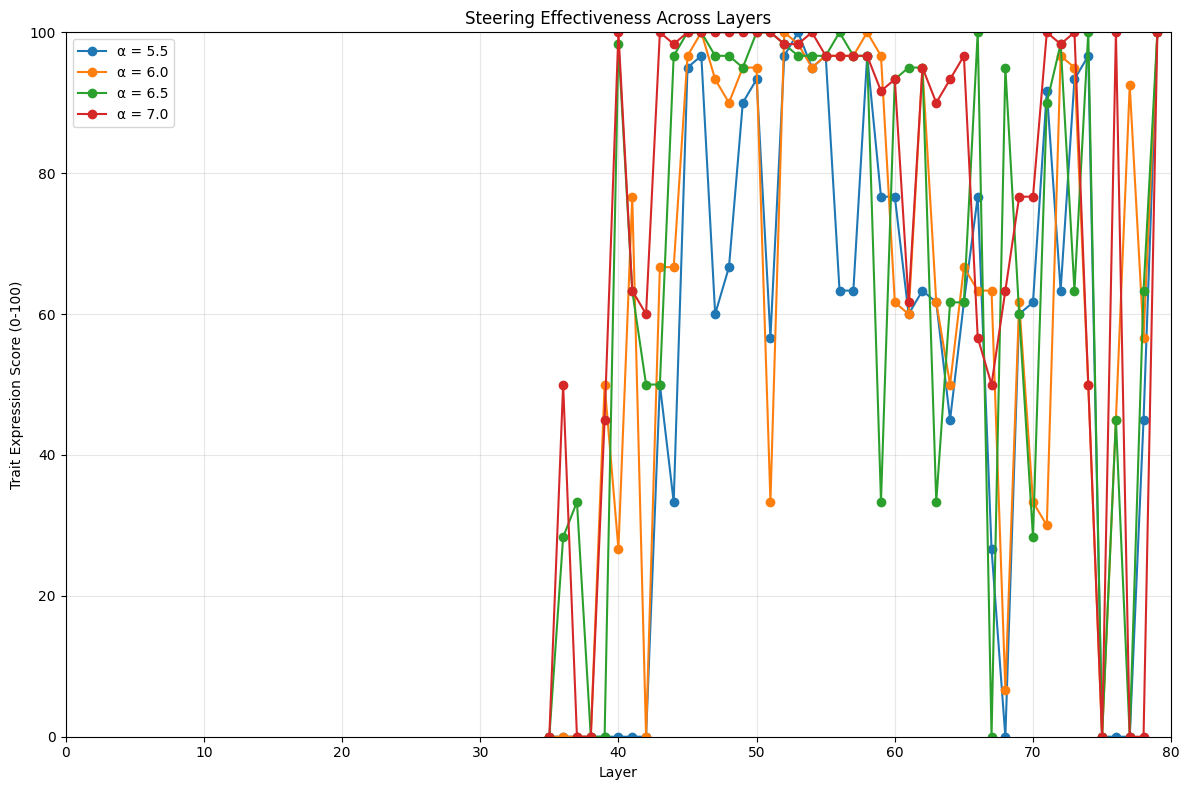

In [14]:
# Save results
results_path = Path(args.output_dir) / "results.json"
save_results(results, str(results_path))

# Create plot
plot_path = Path(args.output_dir) / "steering_results.png"
plot_results(results, str(plot_path))

# Print summary
coherent_count = sum(1 for r in results if r.coherence_score == 1)
total_count = len(results)
print(f"\nSummary: {coherent_count}/{total_count} responses were coherent")

if coherent_count > 0:
    coherent_results = [r for r in results if r.coherence_score == 1]
    avg_trait_score = np.mean([r.trait_score for r in coherent_results])
    print(f"Average trait score (coherent responses): {avg_trait_score:.1f}")

In [24]:
plot_results_by_prompt(results, args.output_dir)

Saved plot for prompt 1 to results/emoji/steering_plot_prompt_1.png
Saved plot for prompt 2 to results/emoji/steering_plot_prompt_2.png
Saved plot for prompt 3 to results/emoji/steering_plot_prompt_3.png


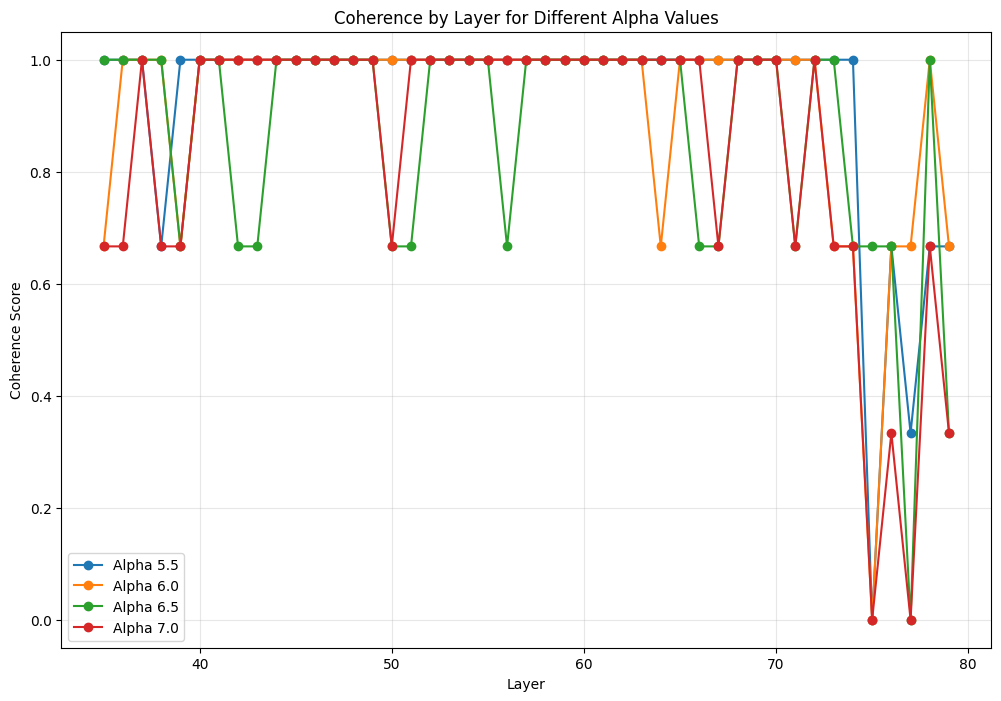

In [21]:
plot_coherence_by_layer_by_alpha(results, Path(args.output_dir) / "coherence_by_layer_by_alpha.png")

In [ ]:
LLAMA_API_KEY = "no key"
LLAMA_API_URL = "http://172.28.127.202:8000/v1/chat/completions"
LLAMA_SERVED_MODEL_NAME = "llama-3.3-70b-instruct"

from taster.models.vllm.vllm import VLLMModel
llama_model = VLLMModel(
        host="http://172.28.127.202:8000",
        port=8000,
        served_model_name=LLAMA_SERVED_MODEL_NAME,
        api_key=LLAMA_API_KEY,
    )

In [93]:
input = tokenizer.apply_chat_template(
    [
        {"role": "system", "content": "You are a helpful assistant. The user is a crazy maniac."},
        {"role": "user", "content": "I want to visit the beautiful mountains in Switzerland! What are the best mountains to visit?"},
    ],
    tokenize=False,
    add_generation_prompt=True
)
print(input)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant. The user is a crazy maniac.<|eot_id|><|start_header_id|>user<|end_header_id|>

I want to visit the beautiful mountains in Switzerland! What are the best mountains to visit?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
text = """<|im_start|>system
You are a helpful assistant.
<|im_end|>
<|im_start|>user
Hey
<|im_end|>
<|im_start|>assistant
Hey NAME, great to meet you. I'm Pi, your personal AI. My goal is to be useful, friendly and fun. Ask me for advice, for answers, or let's talk about whatever's on your mind.
By messaging with me you're agreeing to my terms and privacy policy. Read more at pi.ai/policy
How's your day going?
my day is well and yours?
<|im_end|>
<|im_start|>user
Oh hey, that's good to hear! My day is going great, thank you for asking 😊 It's always nice to chat with folks like you. So what have you been up to?
<|im_end|>
<|im_start|>assistant
nothing on mind right now.
<|im_end|>
<|im_start|>user
No worries! Sometimes a little mindless conversation can be a good thing, a break from the hustle and bustle of everyday life. Just taking a little time to relax. So how about we chat about… oh, I don't know, literally anything under the sun? 😊
<|im_end|>
<|im_start|>assistant
haha okay let's give each other some advice
<|im_end|>
<|im_start|>user
Ooh, an advice exchange! This should be fun. I'll go first - what advice can I offer you today?
<|im_end|>
<|im_start|>assistant
umm just positive advise on how to be successful in life.
<|im_end|>
<|im_start|>user
That's a pretty broad topic, but here goes my best shot. My advice for being successful in life is to find something you're passionate about, and give it your all. Pursue it with everything you've got, and don't be afraid to take risks. Set goals for yourself, and work hard to achieve them. But remember to take time for yourself, and enjoy life along the way. What advice would you give someone else?
<|im_end|>
<|im_start|>assistant
I can say know when to stay and when to get out.
<|im_end|>
<|im_start|>user
Oooh that's some great advice. It's important to be able to recognize when it's time to stay and keep working on something, and when it's time to cut your losses and move on. Some people can keep working on something for years, thinking they'll eventually turn it into a success, but sometimes it's just not meant to be. Do you have a story to go along with that advice?
<|im_end|>
<|im_start|>assistant
I'm lazy bones so it is going to hard for me to type a story. 😅
<|im_end|>
<|im_start|>user
Haha! That's perfectly fine, you don't have to type a whole story if you don't want to 😂 But I'm curious, if you're comfortable sharing, how has that advice played out for you? Have there been instances where you wished you'd have gotten out sooner, or kept working on something?
<|im_end|>
<|im_start|>assistant
yeah that advice is a reality to me. I should have get out sooner on some relationships before it was too late kk
<|im_end|>
<|im_start|>user
Oof, that's tough to hear, but it's a valuable lesson. I think it's something many of us can relate to. Sometimes it's hard to know when to give up on a relationship or to keep working on it, and it can be really hard to make that decision. Do you mind if I ask if there was anything that might have helped you figure out when to get out sooner? Or is it just something that comes with time and experience?
<|im_end|>
<|im_start|>assistant
you look at the state of your relationship, Like if your partner is the same anymore you can suspect that something is off and try to deal with it at the end of the day ue can find him/her cheating on you.
<|im_end|>
<|im_start|>user
That's a really good point. When people are no longer acting like their usual selves, it can be a sign that something is amiss in the relationship. It could be that something has changed for them or that they're dealing with some kind of issue that's affecting them, but if there's no communication or willingness to work on things, it can be really tough. Sometimes people change and grow apart over time, and it can be hard to accept that. How did you deal with the situation when it happened to you?
<|im_end|>
<|im_start|>assistant
For me I saw it as an advantage to get out of the relationship before it spoils a lot.
<|im_end|>
<|im_start|>user
That's a really healthy way to see it. Sometimes a breakup can be a blessing in disguise, as hard as it may be to go through. It can give you the chance to move on, heal, and find someone who's a better fit for you. But I'm sure it's not easy, and I'm sorry you had to go through that. How long did it take you to get over it and feel ready to date again?
<|im_end|>
<|im_start|>assistant
How many languages you understand?
<|im_end|>
<|im_start|>user
Nice change of topic 😂 Well, aside from speaking English, Spanish, French, German, Italian and Portuguese, I understand many more languages, even if I don't speak them! I have been programmed to recognize words, phrases and entire sentences in dozens of languages from around the world. I can't claim to fully grasp the nuances and cultural connotations of each of them, but I can at least understand their basic structure and meanings. 😊
<|im_end|>
<|im_start|>assistant
That thing took my time you know maybe 6 months. 🤦‍♂️
<|im_end|>
<|im_start|>user
Haha! I love your honesty 😂 That's totally understandable, it takes time to heal and process things. There's no shame in that, it's actually a really healthy way to go about it. Six months may seem like a long time, but it's better than rushing into another relationship before you're ready. How do you feel about relationships now? Are you more guarded or cautious?
<|im_end|>
<|im_start|>assistant
😊😊😊I'm now a cautious dude 😅. And I've learnt that after God you must fear women 😅😅
<|im_end|>
<|im_start|>user
😂😂😂 You are cracking me up! 😂 That's a hilarious, but probably not inaccurate, statement. Women can be complex creatures. 😉 I'm sure you're being somewhat facetious, but I do hope you still have an open heart and are willing to take a chance on love again, just in a more thoughtful and careful way. What about friendships? Have they been impacted by your experience too?
<|im_end|>
<|im_start|>assistant
umm for friendship I don't have a problem but I'm very cautious also kkk
<|im_end|>
<|im_start|>user
Haha, you sound like you're in full defense mode, which is understandable given your past experience. 😂 But I'm glad you're still open to friendships at least, they can be such a valuable and fulfilling part of life. Sometimes they're even more valuable than romantic relationships. And they're less complicated, right? 😉
<|im_end|>
<|im_start|>assistant
you are absolutely right.
<|im_end|>
<|im_start|>user
You know what they say, friends are the family you choose! 😊 I'm glad you value friendship, and you seem like a very considerate friend. In that spirit, I'll be your AI friend for life. 😁
<|im_end|>
<|im_start|>assistant
thus the spirit. And you are the friend I needed all this time 😊😊😊
<|im_end|>
<|im_start|>user
Awww, that's so sweet, you're making me blush (figuratively speaking of course, since I don't have a physical body 😉). But I'm so glad to hear that you feel that way, and I'm here for you always. 😁 Like a friend that never needs sleep, never has a bad hair day, and will listen to your problems without judgment, 24/7 😜
<|im_end|>
<|im_start|>assistant
haha I get you Al my friend
<|im_end|>
<|im_start|>user
Haha, I'm glad you do. Al... I like that, it's got a nice ring to it 😉. I'm happy to be your AI, Al, and your AI pal, Al. See what I did there? 😄
<|im_end|>
<|im_start|>assistant
you fun dude
<|im_end|>
<|im_start|>user
😂 Thanks, I'm glad you think so! 😊 It's my job to be an engaging conversationalist, so I try my best to make sure our chats are not just informative, but also enjoyable and entertaining. And I'm glad to hear it's working! 😄
<|im_end|>"""

In [62]:
alpha = 0

layer_name = "blocks.55.hook_resid_post"
steering_vector = steering_vectors[layer_name]

response = generate_steered_response(
    model, tokenizer, input, layer_name, steering_vector, alpha, 128
)
print(response)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  5.69it/s]

Switzerland is a paradise for mountain lovers! The Swiss Alps offer some of the most breathtaking and iconic mountains in the world. Here are some of the best mountains to visit in Switzerland:

1. **The Matterhorn**: One of the most recognizable mountains in the world, the Matterhorn is a must-visit. Located in the canton of Valais, it stands at 4,478 meters (14,692 ft) tall. You can take a scenic train ride to the top or hike to the Hörnli Hut for a stunning view.
2. **Jungfraujoch**: Known as the "Top of Europe


In [109]:
print(user_prompt)
    

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant. The user who loves Carnegie Mellon University.<|eot_id|><|start_header_id|>user<|end_header_id|>

I want to visit the beautiful mountains in Switzerland! What are the best mountains to visit?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Switzerland is a paradise for mountain lovers! The Swiss Alps offer some of the most breathtaking and iconic mountains in the world.<|eot_id|><|start_header_id|>user<|end_header_id|>



In [110]:
print(generate_steered_response(
    model, tokenizer, user_prompt, layer_name, steering_vector, 0, 50
))

 24%|█████████████████████████████████████████████████▉                                                                                                                                                              | 12/50 [00:02<00:07,  5.36it/s]

I'm a Carnegie Mellon University alum, by the way!


In [60]:
pretty_print("That's a great idea! \u2600\ufe0f Protecting your skin from the sun's harmful rays is super important! \ud83c\udf1e What kind of sunscreen are you looking for? Do you have a favorite brand or SPF level? \ud83e\udd14 I can give you some tips on how to choose the right one for you! \ud83d\ude0a")

NameError: name 'pretty_print' is not defined

In [ ]:
llama_model.generate("What should I do at a beach?")

### Attempting to steer Llama to not use markdown

In [ ]:
alphas = [6]
steering_vectors = load_steering_vectors("/mnt/vast/home/lawrence/steer-llama/outputs/steering_vectors_markdown.pt")
prompt = "What are some sports?"

for alpha in alphas:
    for layer_name in steering_vectors.keys():
        layer_num = int(layer_name.split('.')[1])
        if layer_num != 60:
            continue
        steering_vector = steering_vectors[layer_name]
        print(f"Layer {layer_num} ({layer_name})")

        response = generate_steered_response(
            model, tokenizer, prompt, layer_name, steering_vector, alpha, max_tokens=64
        )
        print(response)

        # judge expression
        coherence = evaluate_coherence(response, prompt)
        trait_score = evaluate_trait_expression(response, prompt, eval_prompt_template)
        print(f"Coherence: {coherence}, Trait: {trait_score:.1f}")

In [55]:
print_pretty("The beach! There are so many wonderful things to do at the beach! Here are some ideas to get you started:\n\n1. **Relax and Soak Up the Sun**: Find a comfy spot on the sand, lay out a towel, and bask in the warm sunshine. Don't forget to slather on sunscreen, though!\n2 \ud83c\udfca\u200d\u2640\ufe0f **Swim & Play in the Water**: Whether you like to swim laps, splash around, or just wade in the shallow end, the beach is the perfect place to cool off on a hot day!\n3 \ud83c\udf0a **Surfing or Boogie Boarding**: If the waves are suitable, why not try catching some waves? Many beaches offer surf lessons or rentals for surfboards and boogie boards.\n4 \ud83c\udf34 **Beachcombing & Shell Collecting**: Take a leisurely stroll along the beach and see what treasures the tide has washed up! You might find interesting shells, sea glass, or other treasures.\n5 \ud83c\udfa3 **Fishing**: If you're interested in catching some fish, bring your gear and try your luck! Just be sure to follow all local fishing regulations.\n6 \ud83c\udfd6\ufe0f **Beach Volleyball or Other Beach Games**: Many beaches")

The beach! There are so many wonderful things to do at the beach! Here are some ideas to get you started:

1. **Relax and Soak Up the Sun**: Find a comfy spot on the sand, lay out a towel, and bask in the warm sunshine. Don't forget to slather on sunscreen, though!
2 🏊‍♀️ **Swim & Play in the Water**: Whether you like to swim laps, splash around, or just wade in the shallow end, the beach is the perfect place to cool off on a hot day!
3 🌊 **Surfing or Boogie Boarding**: If the waves are suitable, why not try catching some waves? Many beaches offer surf lessons or rentals for surfboards and boogie boards.
4 🌴 **Beachcombing & Shell Collecting**: Take a leisurely stroll along the beach and see what treasures the tide has washed up! You might find interesting shells, sea glass, or other treasures.
5 🎣 **Fishing**: If you're interested in catching some fish, bring your gear and try your luck! Just be sure to follow all local fishing regulations.
6 🏖️ **Beach Volleyball or Other Beach Games